In [44]:
import numpy as np
import pandas as pd
import unicodedata
import re
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


In [45]:
data = pd.read_csv('output.csv')


In [47]:
data.head()

,province,district,street,price_unit,price_value,price_absolute,area,type,front,room,toilet,floor,attributes,Chung cư,Dòng tiền,Không rõ,Kinh doanh,Mặt phố,Thang máy,Ô tô
0,1,5,Mặt phố C1 TT Nghĩa Tân,1,5.50,"5,500.00",70.00,1,7.00,2,2,1,"Ô tô, Kinh doanh, Dòng tiền",0,1,0,1,0,0,1
1,1,5,Yên Hoà,1,8.58,"8,580.00",45.00,1,5.00,5,4,4,Ô tô,0,0,0,0,0,0,1
2,1,5,Cầu Giấy,1,8.65,"8,650.00",43.00,1,3.60,6,1,5,Không rõ,0,0,1,0,0,0,0
3,1,5,Hồ Tùng Mậu,1,28.50,"28,500.00",100.00,1,6.90,29,0,8,"Ô tô, Dòng tiền, Thang máy",0,1,0,0,0,1,1
4,1,5,Cầu Giấy,1,8.90,"8,900.00",35.00,1,3.40,6,2,5,Không rõ,0,0,1,0,0,0,0


In [48]:

# 1. Loại bỏ khoảng trắng và điền NaN
data['attributes'] = data['attributes'].str.strip()
data['attributes'] = data['attributes'].fillna('Không rõ')  # Loại bỏ inplace=True

# 2. Mã hóa các thuộc tính
attributes_dummies = data['attributes'].str.get_dummies(sep=', ')

# 3. Ghép các cột đã mã hóa vào DataFrame gốc
data = pd.concat([data, attributes_dummies], axis=1)

# 4. Kiểm tra kết quả
print(data.head())


   province  district                   street  price_unit  price_value  \
0         1         5  Mặt phố C1 TT Nghĩa Tân           1         5.50   
1         1         5                  Yên Hoà           1         8.58   
2         1         5                 Cầu Giấy           1         8.65   
3         1         5              Hồ Tùng Mậu           1        28.50   
4         1         5                 Cầu Giấy           1         8.90   

   price_absolute   area  type  front  room  ...  Mặt phố  Thang máy  Ô tô  \
0        5,500.00  70.00     1   7.00     2  ...        0          0     1   
1        8,580.00  45.00     1   5.00     5  ...        0          0     1   
2        8,650.00  43.00     1   3.60     6  ...        0          0     0   
3       28,500.00 100.00     1   6.90    29  ...        0          1     1   
4        8,900.00  35.00     1   3.40     6  ...        0          0     0   

   Chung cư  Dòng tiền  Không rõ  Kinh doanh  Mặt phố  Thang máy  Ô tô  
0      

In [49]:
 # Hàm chuẩn hóa tên đường
def normalize_street_name(street_name):
    # Loại bỏ dấu tiếng Việt
    street_name = unicodedata.normalize('NFKD', street_name).encode('ascii', 'ignore').decode('utf-8')
    # Chuyển thành chữ thường
    street_name = street_name.lower()
    # Loại bỏ các ký tự đặc biệt và khoảng trắng thừa
    street_name = re.sub(r'[^a-z0-9\s]', '', street_name)
    street_name = re.sub(r'\s+', ' ', street_name).strip()
    return street_name

# Áp dụng hàm chuẩn hóa lên cột 'street'
data['street_normalized'] = data['street'].apply(normalize_street_name)

# Thực hiện one-hot encoding sau khi chuẩn hóa
street_encoded = pd.get_dummies(data['street_normalized'], prefix='street')

# Nối cột mới với DataFrame gốc
data = pd.concat([data, street_encoded], axis=1)

# Xóa cột 'street_normalized' nếu không cần thiết nữa
data.drop(columns=['street_normalized'], inplace=True)

# Kiểm tra lại dữ liệu sau khi xử lý
print(data.head())

   province  district                   street  price_unit  price_value  \
0         1         5  Mặt phố C1 TT Nghĩa Tân           1         5.50   
1         1         5                  Yên Hoà           1         8.58   
2         1         5                 Cầu Giấy           1         8.65   
3         1         5              Hồ Tùng Mậu           1        28.50   
4         1         5                 Cầu Giấy           1         8.90   

   price_absolute   area  type  front  room  ...  street_truong cong giai  \
0        5,500.00  70.00     1   7.00     2  ...                    False   
1        8,580.00  45.00     1   5.00     5  ...                    False   
2        8,650.00  43.00     1   3.60     6  ...                    False   
3       28,500.00 100.00     1   6.90    29  ...                    False   
4        8,900.00  35.00     1   3.40     6  ...                    False   

   street_tt van cong mai dich street_tt van hoa nghe thuat mai dich  \
0             

In [50]:
data = data.drop(columns=['street'])


In [51]:
data = data.drop(columns=['attributes'])


In [52]:
data = data.drop(columns=['price_value'])


In [53]:
X = data.drop('price_absolute', axis=1)
y = data['price_absolute']

In [54]:
X.info


<bound method DataFrame.info of      province  district  price_unit     area  type  front  room  toilet  \
0           1         5           1    70.00     1   7.00     2       2   
1           1         5           1    45.00     1   5.00     5       4   
2           1         5           1    43.00     1   3.60     6       1   
3           1         5           1   100.00     1   6.90    29       0   
4           1         5           1    35.00     1   3.40     6       2   
5           1         5           1    60.00     1   3.00     2       1   
6           1         5           1   130.00     1   6.90     2       0   
7           1         5           1   130.00     1   6.90     0       0   
8           1         5           1    77.00     1   7.00     7       3   
9           1         5           1    72.00     1   6.00     8       4   
10          1         5           1    48.00     1   3.50     5       1   
11          1         5           1   212.00     1   7.60     7     

In [55]:
X.shape


(551, 173)

In [56]:
X

,province,district,price_unit,area,type,front,room,toilet,floor,Chung cư,...,street_truong cong giai,street_tt van cong mai dich,street_tt van hoa nghe thuat mai dich,street_tu mo,street_uong 800a,street_vo chi cong,street_xuan thuy,street_xx cau giay,street_xx tran thai tong,street_yen hoa
0,1,5,1,70.00,1,7.00,2,2,1,0,...,False,False,False,False,False,False,False,False,False,False
1,1,5,1,45.00,1,5.00,5,4,4,0,...,False,False,False,False,False,False,False,False,False,True
2,1,5,1,43.00,1,3.60,6,1,5,0,...,False,False,False,False,False,False,False,False,False,False
3,1,5,1,100.00,1,6.90,29,0,8,0,...,False,False,False,False,False,False,False,False,False,False
4,1,5,1,35.00,1,3.40,6,2,5,0,...,False,False,False,False,False,False,False,False,False,False
5,1,5,1,60.00,1,3.00,2,1,1,0,...,False,False,False,False,False,False,False,False,False,False
6,1,5,1,130.00,1,6.90,2,0,2,0,...,False,False,False,False,False,False,False,False,False,False
7,1,5,1,130.00,1,6.90,0,0,2,0,...,False,False,False,False,False,False,False,False,False,False
8,1,5,1,77.00,1,7.00,7,3,4,0,...,False,False,False,False,False,False,False,False,False,False
9,1,5,1,72.00,1,6.00,8,4,4,0,...,False,False,False,False,False,False,False,False,False,False


In [57]:
y.shape


(551,)

In [58]:
from sklearn.model_selection import train_test_split


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)


In [60]:
X_train 

,province,district,price_unit,area,type,front,room,toilet,floor,Chung cư,...,street_truong cong giai,street_tt van cong mai dich,street_tt van hoa nghe thuat mai dich,street_tu mo,street_uong 800a,street_vo chi cong,street_xuan thuy,street_xx cau giay,street_xx tran thai tong,street_yen hoa
297,1,5,1,48.00,1,4.30,2,6,8,0,...,False,False,False,False,True,False,False,False,False,False
323,1,5,1,62.00,1,4.00,5,0,5,0,...,False,False,False,False,False,False,False,False,False,False
459,1,5,1,45.00,1,4.00,5,1,4,0,...,False,False,False,False,False,False,False,False,False,False
209,1,5,1,95.00,1,6.00,3,2,1,1,...,False,False,False,False,False,False,False,False,False,False
143,1,5,1,83.00,1,7.70,10,0,5,1,...,False,False,False,False,False,False,False,False,False,False
468,1,5,1,94.00,1,7.50,10,7,6,0,...,False,False,False,False,False,False,False,False,False,False
225,1,5,1,48.00,1,4.00,9,0,5,0,...,False,False,False,False,False,False,False,False,False,False
318,1,5,1,60.00,1,4.00,7,3,5,0,...,False,False,False,False,False,False,False,False,False,False
216,1,5,1,77.00,1,6.20,10,4,4,0,...,False,False,False,False,False,False,False,False,False,False
53,1,5,1,30.00,1,4.80,5,1,5,0,...,False,False,False,False,False,False,False,False,False,False


In [61]:
X_test


,province,district,price_unit,area,type,front,room,toilet,floor,Chung cư,...,street_truong cong giai,street_tt van cong mai dich,street_tt van hoa nghe thuat mai dich,street_tu mo,street_uong 800a,street_vo chi cong,street_xuan thuy,street_xx cau giay,street_xx tran thai tong,street_yen hoa
220,1,5,1,48.00,1,3.80,2,3,6,0,...,False,False,False,False,False,False,False,False,False,False
18,1,5,1,63.00,1,5.00,12,1,7,0,...,False,False,False,False,False,False,False,False,False,False
391,1,5,1,31.00,1,3.00,7,4,5,0,...,False,False,False,False,False,False,False,False,False,False
141,1,5,1,103.00,1,4.20,0,0,7,0,...,False,False,False,False,False,False,False,False,False,False
354,1,5,1,57.00,1,6.30,0,0,5,0,...,False,False,False,False,False,False,False,False,False,False
116,1,5,1,48.00,1,3.40,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
313,1,5,1,61.00,1,3.30,22,11,6,0,...,False,False,False,False,False,False,False,False,False,False
138,1,5,1,65.00,1,3.40,2,0,4,0,...,False,False,False,False,False,False,False,False,False,False
515,1,5,1,81.00,1,5.50,0,0,4,0,...,False,False,False,False,False,False,False,False,False,False
360,1,5,1,49.00,1,4.20,9,9,5,0,...,False,False,False,False,False,False,False,False,False,False


In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [63]:
X_train = scaler.fit_transform(X_train)


In [64]:
X_test = scaler.transform(X_test)


In [65]:
X_train.shape


(385, 173)

In [66]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [67]:
X_test.shape


(166, 173)

In [70]:
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

# Hàm tạo mô hình
def build_model(hp):
    model = Sequential()

    # Sử dụng Hyperparameters để điều chỉnh số lượng neurons và dropout
    for i in range(4):  # Thêm 4 layers
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=64, step=16),
                        activation='relu',
                        kernel_regularizer=l2(hp.Float('l2_' + str(i), 0.001, 0.1, step=0.01))))
        model.add(Dropout(hp.Float('dropout_' + str(i), 0.1, 0.5, step=0.1)))
    
    # Lớp đầu ra
    model.add(Dense(1))

    # Sử dụng hyperparameter để điều chỉnh learning rate của Adam
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model


In [86]:
from keras_tuner import RandomSearch

# Khởi tạo Keras Tuner
tuner = RandomSearch(
    build_model,  # Hàm tạo mô hình
    objective='val_loss',  # Tối ưu hóa dựa trên validation loss
    max_trials=40,  # Số lần thử nghiệm với các hyperparameter khác nhau
    executions_per_trial=2,  # Số lần chạy mỗi thử nghiệm
    directory='my_dir',  # Thư mục để lưu kết quả
    project_name='house_price_prediction'  # Tên dự án
)


In [87]:
# Bắt đầu tìm kiếm hyperparameters tốt nhất
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Lấy ra mô hình tốt nhất
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of neurons in first layer: {best_hps.get('units_0')}")
print(f"Best dropout rate in first layer: {best_hps.get('dropout_0')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best L2 rate :{best_hps.get('l2_0')}")


Trial 40 Complete [00h 00m 37s]
val_loss: 18641014784.0

Best val_loss So Far: 3261678080.0
Total elapsed time: 00h 25m 05s
Best number of neurons in first layer: 64
Best dropout rate in first layer: 0.1
Best learning rate: 0.007354966228502024
Best L2 rate :0.07100000000000001


In [80]:
# Lấy mô hình tốt nhất từ Keras Tuner và huấn luyện lại mô hình
best_model = tuner.hypermodel.build(best_hps)

In [81]:

# Huấn luyện lại mô hình tốt nhất từ Keras Tuner
history = best_model.fit(
    X_train, y_train, 
    epochs=200,  # Số lượng epochs tối đa
    batch_size=128,  # Sử dụng batch_size = 32
    validation_data=(X_test, y_test),  # Validation data để đánh giá mô hình
    verbose=1  # Hiển thị chi tiết quá trình huấn luyện
)

# Dự đoán trên tập kiểm tra
y_test_pred = best_model.predict(X_test)

# Tính toán các chỉ số đánh giá: MSE, MAE, R² và RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np  # Thêm numpy để tính căn bậc hai

# Tính các chỉ số
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
rmse = np.sqrt(mse)  # Tính RMSE bằng cách lấy căn bậc hai của MSE

# In kết quả
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')
print(f'RMSE: {rmse}')


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 2937771008.0000 - val_loss: 22826805248.0000
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4661502464.0000 - val_loss: 22826647552.0000
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2748866304.0000 - val_loss: 22826264576.0000
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5058834944.0000 - val_loss: 22825433088.0000
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5023460864.0000 - val_loss: 22823346176.0000
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3412043264.0000 - val_loss: 22818144256.0000
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5201494528.0000 - val_loss: 22806063104.0000
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2887807232.0000 - val_loss: 22779273216.0000
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2942196224.0000 - val_loss: 22726752256.0000
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3333069312.000

In [82]:
y_test_pred = best_model.predict(X_test)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [83]:
y_test

220      17,500.00
18       16,500.00
391       7,550.00
141      44,000.00
354      14,500.00
116      26,500.00
313      13,500.00
138      22,500.00
515      25,500.00
360       8,600.00
236      16,700.00
8        23,600.00
437      13,900.00
505      22,000.00
39        8,600.00
277      72,000.00
55        5,550.00
171      15,200.00
228       5,950.00
413      31,500.00
269      25,500.00
290       9,800.00
521      16,000.00
83       22,000.00
48      195,000.00
540      20,500.00
156      39,500.00
317      13,200.00
147      36,500.00
377       5,750.00
114      18,800.00
186      15,200.00
118       6,050.00
32      142,000.00
117      71,000.00
291       9,300.00
183      55,000.00
400      16,500.00
427      32,000.00
218     120,000.00
486       5,200.00
0         5,500.00
107      27,300.00
4         8,900.00
139      19,700.00
535      12,700.00
283      35,000.00
265       6,980.00
179      24,000.00
450      51,000.00
100      12,000.00
255      15,900.00
359      14,

In [84]:
import pandas as pd

# Chuyển đổi giá trị dự đoán và giá trị thực thành DataFrame để tiện so sánh
df_comparison = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_test_pred.flatten()})

# Định dạng các số bằng cách giới hạn số chữ số thập phân
pd.options.display.float_format = '{:,.2f}'.format

# Hiển thị kết quả
print(df_comparison)


          Actual  Predicted
0      17,500.00  17,595.35
1      16,500.00   8,946.57
2       7,550.00   9,854.15
3      44,000.00  26,310.83
4      14,500.00   9,840.94
5      26,500.00  38,467.64
6      13,500.00  32,562.49
7      22,500.00   5,545.88
8      25,500.00  14,066.92
9       8,600.00  15,140.75
10     16,700.00  18,897.21
11     23,600.00  12,530.17
12     13,900.00   7,318.02
13     22,000.00  45,139.37
14      8,600.00   7,410.42
15     72,000.00  43,622.93
16      5,550.00   8,544.83
17     15,200.00  20,304.27
18      5,950.00   7,930.27
19     31,500.00  12,855.29
20     25,500.00  76,867.94
21      9,800.00  47,126.02
22     16,000.00  20,452.14
23     22,000.00  17,474.66
24    195,000.00  79,398.93
25     20,500.00  15,899.10
26     39,500.00  45,918.79
27     13,200.00   9,943.60
28     36,500.00  17,575.94
29      5,750.00  28,076.29
30     18,800.00  14,692.22
31     15,200.00  26,678.36
32      6,050.00  37,876.04
33    142,000.00 102,139.22
34     71,000.00  20

In [43]:
# Tính sai số tuyệt đối
df_comparison['Absolute Error'] = abs(df_comparison['Actual'] - df_comparison['Predicted'])

# Sắp xếp DataFrame theo sai số từ cao xuống thấp
df_comparison_sorted = df_comparison.sort_values(by='Absolute Error', ascending=False)

# Hiển thị 10 kết quả có sai số lớn nhất
print(df_comparison_sorted.head(10))


          Actual    Predicted  Absolute Error
158 1,550,000.00   978,852.56      571,147.44
60    320,000.00    45,319.15      274,680.85
64    350,000.00   183,470.36      166,529.64
81     18,500.00   177,300.81      158,800.81
85    920,000.00 1,057,658.75      137,658.75
119   225,000.00    90,322.91      134,677.09
65    285,000.00   167,502.28      117,497.72
20     25,500.00   140,502.09      115,002.09
100    13,700.00   120,046.83      106,346.83
39    120,000.00    39,265.23       80,734.77


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Tính toán các chỉ số lỗi
mse = mean_squared_error(df_comparison['Actual'], df_comparison['Predicted'])
mae = mean_absolute_error(df_comparison['Actual'], df_comparison['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(df_comparison['Actual'], df_comparison['Predicted'])

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


MSE: 3798808862.423448
MAE: 27833.259974326993
RMSE: 61634.47787094045
R²: 0.8179549285572926


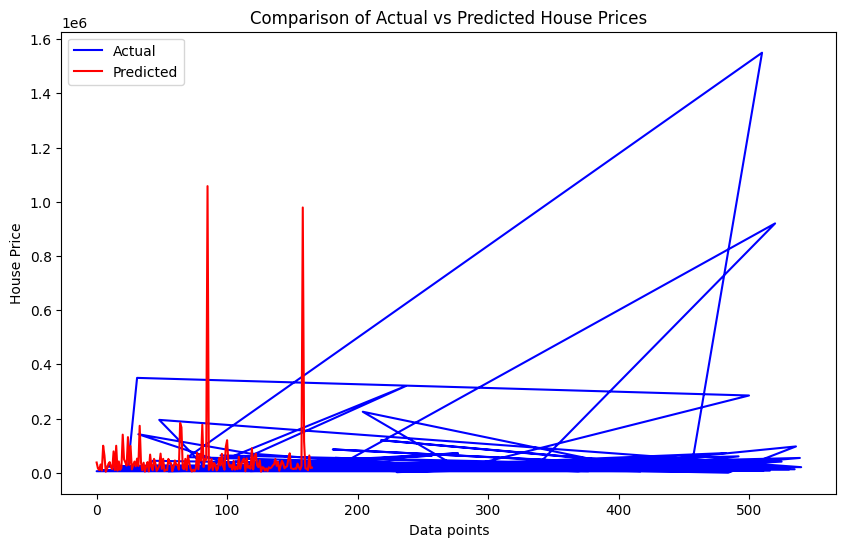

In [35]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ giá trị thực tế và giá trị dự đoán
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='red')
plt.title('Comparison of Actual vs Predicted House Prices')
plt.xlabel('Data points')
plt.ylabel('House Price')
plt.legend()
plt.show()


In [35]:
from tensorflow.python.keras.callbacks import EarlyStopping

# Tạo mô hình Sequential
model = Sequential()

# Thêm các lớp Dense với L2 Regularization và Dropout
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Lớp Dense với regularization L2
model.add(Dropout(0.4))  # Dropout để ngăn chặn overfitting

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Lớp Dense với L2
model.add(Dropout(0.3))  # Dropout

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Lớp Dense với L2
model.add(Dropout(0.3))  # Dropout

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Lớp Dense với L2
model.add(Dropout(0.3))  # Dropout

# Lớp đầu ra
model.add(Dense(1))

# Biên dịch mô hình với Adam optimizer và MSE loss function
optimizer = Adam(learning_rate=0.009)  # Sử dụng Adam với learning rate thấp hơn
model.compile(optimizer=optimizer, loss='mse')

# Thêm Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [24]:

model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=32,epochs=200, callbacks=[early_stopping])

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 4058074880.0000 - val_loss: 22826743808.0000
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3184622848.0000 - val_loss: 22826080256.0000
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2916363008.0000 - val_loss: 22821613568.0000
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3444310784.0000 - val_loss: 22797404160.0000
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5637350912.0000 - val_loss: 22703751168.0000
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4284162304.0000 - val_loss: 22400505856.0000
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1504294784.0000 - val_loss: 21689960448.0000
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3208595968.0000 - val_loss: 20855971840.0000
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4276307200.0000 - val_loss: 20540567552.0000
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 349

In [36]:
losses = pd.DataFrame(model.history.history)


<Axes: >

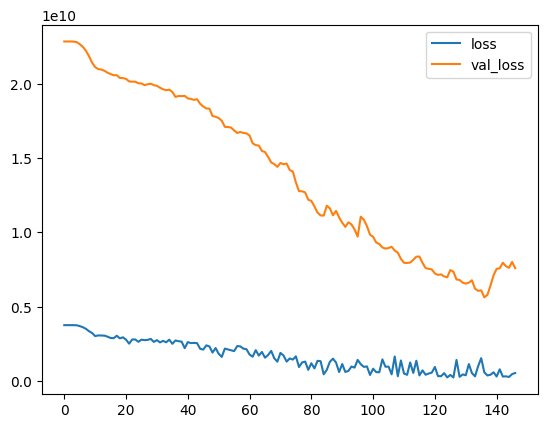

In [37]:
losses.plot()


In [40]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])